# 🚀 Mid-Layer Early-Exit 可视化演示（Token 级别）

本 notebook 展示 **Dual Cache + Mid-Layer Early-Exit** 策略。

**工作原理：**
- 使用 **Dual Cache** 加速：缓存 KV，只处理当前 block
- 在每个 refinement step 中，先计算到第 k 层（`early_exit_layer`）
- **按 TOKEN** 比较当前 hidden state 与上一步同一层的 **cosine similarity**
- 对于相似度 > 阈值的 **token**，跳过后续层计算，复用上一步的 hidden state 和 KV

**与 Token Skip 的区别：**
- Token Skip: 跳过某些 token 的计算（复用 logits，不减少计算）
- Mid-Layer Skip: **按 TOKEN** 跳过后续层的计算（复用 hidden state + KV，真正减少计算）

**关键参数：**
- `early_exit_layer`: 在哪一层做判断（推荐 16-26）
- `early_exit_threshold`: cosine similarity 阈值（推荐 0.9）

**跳过的内容（对于满足条件的 token）：**
- Hidden state: 使用上一步的
- KV cache: 使用上一步的（保证一致性）

## 1. 环境设置

In [1]:
import os
import torch
import gc

# Set GPU (modify according to your environment)
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# Change to llada directory
os.chdir('llada')

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

CUDA available: True
GPU: NVIDIA RTX A5000
Total VRAM: 22.06 GB


## 2. 加载模型

In [2]:
from transformers import AutoTokenizer
from model.modeling_llada import LLaDAModelLM

device = 'cuda'
model_name = 'GSAI-ML/LLaDA-8B-Instruct'

print(f"Loading model: {model_name}")
model = LLaDAModelLM.from_pretrained(
    model_name, 
    trust_remote_code=True, 
    torch_dtype=torch.bfloat16
).to(device).eval()

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
print("✅ Model loaded!")

/data/houpu/miniconda3/envs/fastllm/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading model: GSAI-ML/LLaDA-8B-Instruct


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

✅ Model loaded!


## 3. 运行 Mid-Layer Early-Exit 生成

关键参数：
- `early_exit_layer`: 在哪一层做 early-exit 判断（0-based），LLaDA-8B 有 32 层
- `early_exit_threshold`: cosine similarity 阈值
- `enable_skip`: 是否启用 early-exit（设为 False 可对比基线）

In [10]:
from generate import generate_with_mid_layer_skip, generate_with_dual_cache_token_skip

# Define your prompt
prompt_text = "Who is Newton?"

# Prepare input
m = [{"role": "user", "content": prompt_text}]
prompt = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
input_ids = tokenizer(prompt)['input_ids']
input_ids = torch.tensor(input_ids).to(device).unsqueeze(0)
prompt_len = input_ids.shape[1]

print(f"Prompt length: {prompt_len} tokens")
print(f"Prompt: {prompt_text}")
print("\n🚀 Running generation with Mid-Layer Early-Exit...")

# Run generation (parameters are adjustable)
x, nfe, stats, step_history = generate_with_mid_layer_skip(
    model, 
    input_ids,
    steps=32,                    # total steps
    gen_length=64,               # generation length
    block_length=32,             # block length
    temperature=0.,              # sampling temperature
    threshold=0.9,               # token transfer threshold
    early_exit_layer=24,         # early-exit decision at layer 24
    early_exit_threshold=0.9,    # cosine similarity threshold
    enable_skip=True,            # enable early-exit
    return_trace=True,
)

print(f"\nDone!")
print(f"   NFE (forward passes): {nfe}")
print(f"   Total steps: {stats['total_steps']}")
print(f"   Early-Exit triggered steps: {stats['early_exit_count']}")
print(f"   Full compute steps: {stats['full_compute_count']}")
print(f"   Early-Exit step rate: {stats.get('early_exit_rate', 0)*100:.1f}%")
print(f"   Skipped tokens total: {stats['skipped_tokens_total']}")

# Display generated result
result = tokenizer.decode(x[0, prompt_len:], skip_special_tokens=True)
print(f"\nGenerated answer:\n{result}")

Prompt length: 17 tokens
Prompt: Who is Newton?

🚀 Running generation with Mid-Layer Early-Exit...

Done!
   NFE (forward passes): 32
   Total steps: 32
   Early-Exit triggered steps: 30
   Full compute steps: 2
   Early-Exit step rate: 93.8%
   Skipped tokens total: 668

Generated answer:
Newton is a reference to Sir Isaac Newton, an English mathematician, physicist, astronomer,.


In [11]:
# DEBUG: Compare with original function to find the bug
print("="*60)
print("DEBUG: Comparing generate_with_mid_layer_skip vs original")
print("="*60)

# Test 1: Original function (baseline)
x_orig, nfe_orig, _, _ = generate_with_dual_cache_token_skip(
    model, input_ids,
    steps=32, gen_length=64, block_length=32,
    temperature=0., threshold=0.9,
    enable_skip=False,  # No skip
    return_trace=True,
)
answer_orig = tokenizer.decode(x_orig[0, prompt_len:], skip_special_tokens=True)
print(f"\n1. Original function (no skip):")
print(f"   NFE: {nfe_orig}")
print(f"   Answer: {answer_orig}")

# Test 2: New function with enable_skip=False
x_new_noskip, nfe_new_noskip, stats_new_noskip, _ = generate_with_mid_layer_skip(
    model, input_ids,
    steps=32, gen_length=64, block_length=32,
    temperature=0., threshold=0.9,
    early_exit_layer=24,
    early_exit_threshold=0.9,
    enable_skip=False,  # No skip
    return_trace=True,
)
answer_new_noskip = tokenizer.decode(x_new_noskip[0, prompt_len:], skip_special_tokens=True)
print(f"\n2. New function (enable_skip=False):")
print(f"   NFE: {nfe_new_noskip}")
print(f"   Answer: {answer_new_noskip}")

# Test 3: New function with enable_skip=True but layer=31 (should rarely trigger)
x_new_skip, nfe_new_skip, stats_new_skip, _ = generate_with_mid_layer_skip(
    model, input_ids,
    steps=32, gen_length=64, block_length=32,
    temperature=0., threshold=0.9,
    early_exit_layer=24,
    early_exit_threshold=0.9,
    enable_skip=True,
    return_trace=True,
)
answer_new_skip = tokenizer.decode(x_new_skip[0, prompt_len:], skip_special_tokens=True)
print(f"\n3. New function (enable_skip=True, layer=24):")
print(f"   NFE: {nfe_new_skip}")
print(f"   Early-Exit count: {stats_new_skip['early_exit_count']}")
print(f"   Skipped tokens: {stats_new_skip['skipped_tokens_total']}")
print(f"   Answer: {answer_new_skip}")

# Compare
print(f"\n" + "="*60)
print("COMPARISON:")
print(f"   Original vs New(no skip) match: {answer_orig.strip() == answer_new_noskip.strip()}")
print(f"   Original vs New(skip) match: {answer_orig.strip() == answer_new_skip.strip()}")

DEBUG: Comparing generate_with_mid_layer_skip vs original

1. Original function (no skip):
   NFE: 17
   Answer: Newton is a character in the

2. New function (enable_skip=False):
   NFE: 17
   Answer: Newton is a character in the

3. New function (enable_skip=True, layer=24):
   NFE: 32
   Early-Exit count: 30
   Skipped tokens: 668
   Answer: Newton is a reference to Sir Isaac Newton, an English mathematician, physicist, astronomer,.

COMPARISON:
   Original vs New(no skip) match: True
   Original vs New(skip) match: False


## 4. 查看每一步的 Early-Exit 情况

In [5]:
import pandas as pd

# Display step-by-step info
step_info = []
for s in step_history:
    step_info.append({
        'step': s['step'],
        'block': s['block'],
        'block_step': s['block_step'],
        'early_exit': '✅' if s['early_exit'] else '❌',
        'cos_sim': f"{s['cos_sim']:.4f}" if s['cos_sim'] else '-',
        'transferred': s.get('transferred_count', '-'),
    })

df = pd.DataFrame(step_info)
print("Early-Exit Status per Step:")
display(df)

Early-Exit Status per Step:


,step,block,block_step,early_exit,cos_sim,transferred
0,1,0,0,❌,-,1
1,2,0,1,✅,0.8125,10
2,3,0,2,✅,0.7812,6
3,4,0,3,✅,0.7617,1
4,5,0,4,✅,0.9062,1
5,6,0,5,✅,0.8672,1
6,7,0,6,✅,0.8984,1
7,8,0,7,✅,0.8516,9
8,9,0,8,✅,0.7305,1
9,10,0,9,✅,0.9688,1


## 5. 对比实验：不同 Early-Exit Layer

测试不同的 `early_exit_layer` 对 early-exit 率和生成质量的影响：

In [6]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

# Test different early_exit_layer values
layers_to_test = [16, 20, 24, 26, 28]
threshold = 0.9  # Fixed threshold
results = []

test_prompt = "Lily can run 12 km/h for 4 hours. After that, she runs 6 km/h. How many km can she run in 8 hours?"
m = [{"role": "user", "content": test_prompt}]
prompt = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
input_ids = torch.tensor(tokenizer(prompt)['input_ids']).to(device).unsqueeze(0)
prompt_len = input_ids.shape[1]

print(f"Testing prompt: {test_prompt}")
print(f"Fixed threshold: {threshold}")
print("="*60)

for layer in layers_to_test:
    x, nfe, stats, _ = generate_with_mid_layer_skip(
        model, input_ids,
        steps=32, gen_length=64, block_length=32,
        temperature=0., threshold=0.9,
        early_exit_layer=layer,
        early_exit_threshold=threshold,
        enable_skip=True,
        return_trace=True,
    )
    answer = tokenizer.decode(x[0, prompt_len:], skip_special_tokens=True)
    
    # Estimate potential savings
    num_layers = 32
    potential_savings = (num_layers - layer - 1) / num_layers * 100
    
    results.append({
        'exit_layer': layer,
        'early_exit_rate': f"{stats.get('early_exit_rate', 0)*100:.1f}%",
        'exit_count': stats['early_exit_count'],
        'skipped_tokens': stats.get('skipped_tokens_total', 0),
        'token_skip_rate': f"{stats.get('token_skip_rate', 0)*100:.1f}%",
        'nfe': nfe,
        'answer': answer[:80] + '...' if len(answer) > 80 else answer
    })
    
    print(f"Layer {layer}: Early-Exit rate={stats.get('early_exit_rate', 0)*100:.1f}%, Potential savings={potential_savings:.1f}%")

print()
print("="*60)
df = pd.DataFrame(results)
display(df)

Testing prompt: Lily can run 12 km/h for 4 hours. After that, she runs 6 km/h. How many km can she run in 8 hours?
Fixed threshold: 0.9
Layer 16: Early-Exit rate=93.8%, Potential savings=46.9%
Layer 20: Early-Exit rate=93.8%, Potential savings=34.4%
Layer 24: Early-Exit rate=93.8%, Potential savings=21.9%
Layer 26: Early-Exit rate=93.8%, Potential savings=15.6%
Layer 28: Early-Exit rate=93.8%, Potential savings=9.4%



,exit_layer,early_exit_rate,exit_count,skipped_tokens,token_skip_rate,nfe,answer
0,16,93.8%,30,900,93.8%,32,"In the first 4 hours, 12 8 km.\nIn the next 24 km.\n km.\n 66"
1,20,93.8%,30,818,85.2%,32,"In the first 4 hours, at 12 km/h, she runs 48 km8 + 24 = \boxed{72}$ km."
2,24,93.8%,30,777,80.9%,32,"In the first 4 hours, she runs 12 km/h 4 hours = 48 km.48 km + 22 km = 72 km."
3,26,93.8%,30,777,80.9%,32,"In the first 4 hours, she runs 12 km/h 4 = 48 km./h 4 = 24 km 48 km + 24 km = 72..."
4,28,93.8%,30,778,81.0%,32,"In the first 4 hours, she runs 12 km x 4 = 48 km. km x 48 + 24 = 72 km.\n: 72"


## 6. 对比：启用 vs 禁用 Early-Exit

验证 Early-Exit 是否影响生成质量：

In [7]:
# Disable early-exit (baseline)
x_baseline, nfe_baseline, stats_baseline, _ = generate_with_mid_layer_skip(
    model, input_ids,
    steps=32, gen_length=64, block_length=32,
    temperature=0., threshold=0.9,
    early_exit_layer=24,
    early_exit_threshold=0.9,
    enable_skip=False,  # Disabled
    return_trace=True,
)
answer_baseline = tokenizer.decode(x_baseline[0, prompt_len:], skip_special_tokens=True)

# Enable early-exit
x_skip, nfe_skip, stats_skip, _ = generate_with_mid_layer_skip(
    model, input_ids,
    steps=32, gen_length=64, block_length=32,
    temperature=0., threshold=0.9,
    early_exit_layer=24,
    early_exit_threshold=0.9,
    enable_skip=True,  # Enabled
    return_trace=True,
)
answer_skip = tokenizer.decode(x_skip[0, prompt_len:], skip_special_tokens=True)

print("Baseline (no early-exit):")
print(f"   Answer: {answer_baseline}")
print(f"   NFE: {nfe_baseline}")

print("\nWith Early-Exit:")
print(f"   Answer: {answer_skip}")
print(f"   NFE: {nfe_skip}")
print(f"   Early-Exit rate: {stats_skip.get('early_exit_rate', 0)*100:.1f}%")
print(f"   Skipped tokens: {stats_skip.get('skipped_tokens_total', 0)}")

print("\nComparison:")
print(f"   Answers match: {answer_baseline.strip() == answer_skip.strip()}")

Baseline (no early-exit):
   Answer: In the first 4 hours, Lily runs 12 km/h 4 = 48 km.
 the 6 km/h 4 = 48 km + 24 km = 72 km.
: 72
   NFE: 32

With Early-Exit:
   Answer: In the first 4 hours, she runs 12 km/h 4 hours = 48 km.48 km + 22 km = 72 km.
   NFE: 32
   Early-Exit rate: 93.8%
   Skipped tokens: 777

Comparison:
   Answers match: False


## 7. 可视化 Early-Exit 触发情况

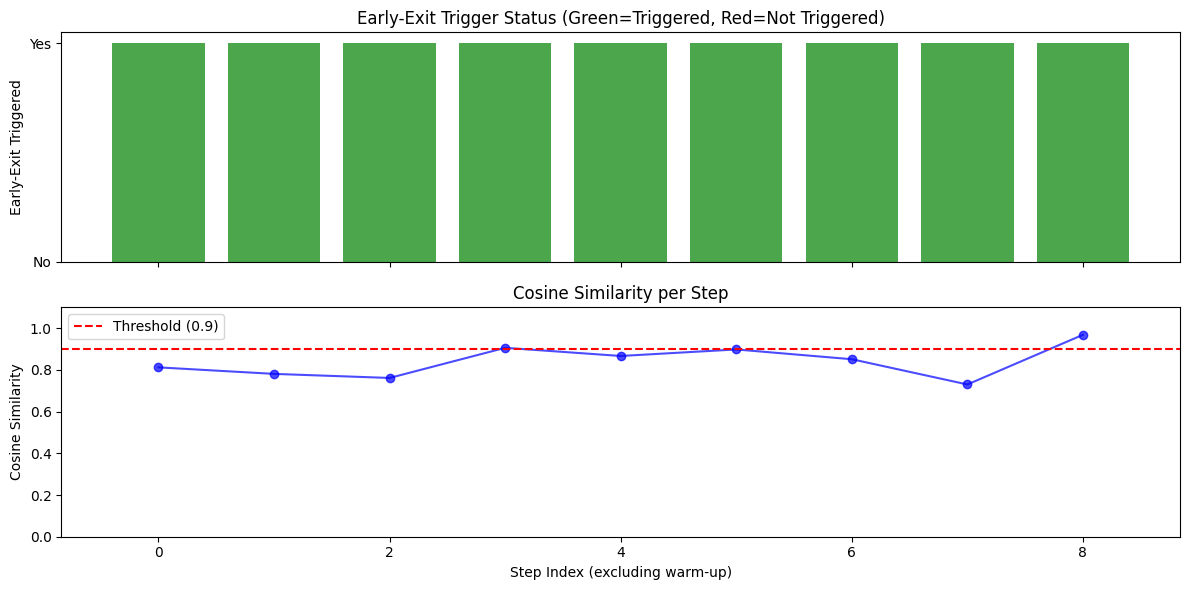


Statistics:
   Total steps (Exclude warm-up): 9
   Early-Exit triggered: 9 (100.0%)
   Average Cosine Similarity: 0.8420


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Collect early-exit status and cosine similarity for each step
steps = [s['step'] for s in step_history if s['block_step'] > 0]  # Exclude warm-up
early_exits = [1 if s['early_exit'] else 0 for s in step_history if s['block_step'] > 0]
cos_sims = [s['cos_sim'] if s['cos_sim'] else 0 for s in step_history if s['block_step'] > 0]

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Top: Early-Exit trigger status
ax1 = axes[0]
colors = ['green' if e else 'red' for e in early_exits]
ax1.bar(range(len(steps)), early_exits, color=colors, alpha=0.7)
ax1.set_ylabel('Early-Exit Triggered')
ax1.set_title('Early-Exit Trigger Status (Green=Triggered, Red=Not Triggered)')
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['No', 'Yes'])

# Bottom: Cosine Similarity
ax2 = axes[1]
ax2.plot(range(len(steps)), cos_sims, marker='o', color='blue', alpha=0.7)
ax2.axhline(y=0.9, color='red', linestyle='--', label=f'Threshold (0.9)')
ax2.set_xlabel('Step Index (excluding warm-up)')
ax2.set_ylabel('Cosine Similarity')
ax2.set_title('Cosine Similarity per Step')
ax2.legend()
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nStatistics:")
print(f"   Total steps (Exclude warm-up): {len(steps)}")
print(f"   Early-Exit triggered: {sum(early_exits)} ({sum(early_exits)/len(steps)*100:.1f}%)")
print(f"   Average Cosine Similarity: {np.mean([c for c in cos_sims if c > 0]):.4f}")

---

## 📖 参数说明

| 参数 | 含义 | 推荐值 |
|------|------|--------|
| `early_exit_layer` | 在哪一层做 early-exit 判断 | 24（保守）, 20（折中）, 16（激进）|
| `early_exit_threshold` | cosine similarity 阈值 | 0.9 |
| `enable_skip` | 是否启用 early-exit | True |

### Trade-off
- **越早判断（layer 越小）** → 节省越多计算 → 风险越高
- **越晚判断（layer 越大）** → 节省越少 → 越安全

### 与 Token Skip 的区别
| 方法 | 跳过对象 | 节省方式 |
|------|----------|----------|
| Token Skip | 某些 token | 复用上一步的 logits |
| Mid-Layer Skip | 某些层 | 复用上一步的 hidden states |